# Homework 3 - Jingwen Li

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology`,
- the market data file `market_prices_eod` and
- the corporate bonds call schedule file `call_schedules`.


# Problem 1: More details on callable bonds: "workout-date" and "yield-to-worst" calculations

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

## a. Load and explore the call schedules dataframe

Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.

For each bond in the dataframe, compute the total number of outstanding calls.

In [48]:
call_schedules = pd.read_excel('call_schedules.xlsx')

In [49]:
call_schedules['call_price'].unique()

array([100])

In [50]:
call_schedules

,isin,figi,call_date,call_price
0,US254687CZ75,BBG00QNKJ092,2024-06-15,100
1,US254687DD54,BBG00QNKPCL5,2025-07-15,100
2,US254687DK97,BBG00QNKGJP6,2026-08-15,100
3,US254687EX00,BBG00QNKKP22,2045-04-15,100
4,US254687FB70,BBG00QNKKP68,2046-05-15,100
...,...,...,...,...
110,US92346MHV63,BBG012F6PR25,2031-03-15,100
111,US92346MJS17,BBG0175X1628,2023-05-15,100
112,US92346MJZ59,BBG017QYK9Z0,2023-06-15,100
113,US92346MKG59,BBG0191HMXJ3,2023-08-15,100


In [51]:
outstanding_calls = call_schedules.groupby(['isin', 'figi'])['call_price'].sum().reset_index()
outstanding_calls['num_call_dates'] = outstanding_calls['call_price']/100
outstanding_calls.drop(columns='call_price', inplace=True)

In [160]:
outstanding_calls = call_schedules.merge(outstanding_calls, on=['isin', 'figi'], how='inner')
outstanding_calls

,isin,figi,call_date,call_price,num_call_dates
0,US254687CZ75,BBG00QNKJ092,2024-06-15,100,1.0
1,US254687DD54,BBG00QNKPCL5,2025-07-15,100,1.0
2,US254687DK97,BBG00QNKGJP6,2026-08-15,100,1.0
3,US254687EX00,BBG00QNKKP22,2045-04-15,100,1.0
4,US254687FB70,BBG00QNKKP68,2046-05-15,100,1.0
...,...,...,...,...,...
110,US92346MHV63,BBG012F6PR25,2031-03-15,100,16.0
111,US92346MJS17,BBG0175X1628,2023-05-15,100,1.0
112,US92346MJZ59,BBG017QYK9Z0,2023-06-15,100,1.0
113,US92346MKG59,BBG0191HMXJ3,2023-08-15,100,1.0


## b. Load symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.

Load the `corp_symbology` Excel file into a dataframe and keep only the fixed-rate callable bonds from 1a.

Extend the dataframe with the column computed in 1a:

| num_call_dates |
|----------|

In [161]:
crop_symbology = pd.read_excel('corp_symbology.xlsx')
crop_symbology.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,US91282CGM73,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.550,...,2,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,AT MATURITY,Sr Unsecured,US,USD
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,US91282CGM73,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.200,...,2,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,AT MATURITY,Sr Unsecured,US,USD


In [162]:
crop_symbology = crop_symbology[(crop_symbology['mty_typ'] == 'CALLABLE') & (crop_symbology['cpn_type'] == 'FIXED')]
callable_crop_bonds = crop_symbology.merge(outstanding_calls, on=['isin', 'figi'], how='inner')
callable_crop_bonds

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_first,acc_first,maturity,mty_typ,rank,country,currency,call_date,call_price,num_call_dates
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD,2024-06-15,100,1.0
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD,2025-07-15,100,1.0
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,2020-05-15,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,US,USD,2026-08-15,100,1.0
3,DIS,Corp,BBG00QNKKP22,US254687EX00,DIS4920157,US912810TQ13,DIS 4.95 10/15/45,WALT DISNEY COMPANY/THE,GLOBAL,4.950,...,2020-04-15,2019-10-15,2045-10-15,CALLABLE,Sr Unsecured,US,USD,2045-04-15,100,1.0
4,DIS,Corp,BBG00QNKKP68,US254687FB70,DIS4907442,US912810TQ13,DIS 4 3/4 11/15/46,WALT DISNEY COMPANY/THE,GLOBAL,4.750,...,2020-05-15,2019-11-15,2046-11-15,CALLABLE,Sr Unsecured,US,USD,2046-05-15,100,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,VZ,Corp,BBG012F6PR25,US92346MHV63,VZ5256196,US912810TL26,VZ 3.05 09/15/51,VERIZON COMMUNICATIONS,DOMESTIC MTN,3.050,...,2022-03-15,2021-09-16,2051-09-15,CALLABLE,Sr Unsecured,US,USD,2031-03-15,100,16.0
111,VZ,Corp,BBG0175X1628,US92346MJS17,VZ5410330,US912810TL26,VZ 4.55 05/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.550,...,2022-11-15,2022-05-12,2052-05-15,CALLABLE,Sr Unsecured,US,USD,2023-05-15,100,1.0
112,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,US912810TL26,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,...,2022-12-15,2022-06-03,2052-06-15,CALLABLE,Sr Unsecured,US,USD,2023-06-15,100,1.0
113,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,US912810TL26,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,...,2023-02-15,2022-08-11,2052-08-15,CALLABLE,Sr Unsecured,US,USD,2023-08-15,100,1.0


In [281]:
callable_crop_bonds.columns

Index(['ticker', 'class', 'figi', 'isin', 'trace', 'und_bench_isin',
       'security', 'name', 'type', 'coupon', 'cpn_type', 'dcc', 'cpn_freq',
       'days_settle', 'start_date', 'cpn_first', 'acc_first', 'maturity',
       'mty_typ', 'rank', 'country', 'currency', 'call_date', 'call_price',
       'num_call_dates'],
      dtype='object')

## c. Add a function to compute "workout date" and "yield-to-worst" for a fixed-rate callable bond

Quick recap: given the current market price, the issuer is expected to call a callable bond on the call date corresponding to lowest bond yield "to call date" (which is the best possible scenario from the point of view of the issuer exercising the call option). The lowest yield for a call date is called the "yield-to-worst" and the corresponding call date (on which the issuer is expected to call the bond) is called the "workout date". Keep in mind that the "workout date" could be at the bond maturity date, in which case "yield-to-worst" = "yield-to-maturity".

To do: For a callable bond, with known symbology (reference data) and call schedules dataframes, create a function that takes the clean market price as an input and returns "workout date" and "yield-to-worst".

Internally, for each call date, create a separate "call scenario bond" object using the function create_bond_from_symbology() from Homework 2, and then compute the corresponding "call scenario yield" for the "call scenario bond" (using the bond clean market price).


In [320]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

In [321]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [322]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])   # use date helper function and update code !!!
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])   # use date helper function and update code !!!
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

In [323]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['class_x'] == 'Govt':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        day_count = ql.Thirty360(ql.Thirty360.USA)
        # update code depending on dcc !!!
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])    # use date helper function and update code !!!
    
    # Create days_settle from details['days_settle']
    days_settle = details['days_settle']

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

In [324]:
def calc_yield_to_worst(
            details: dict,
            pc_schedule: pd.DataFrame,
            bond_clean_price: float,
            calc_date: ql.Date):
    '''Computes yield-to-worst and workout date for fixed rate callable bonds.
    '''  
    workout_date = ql.Date()
    yield_to_worst = details['yield_to_maturity']
    accuracy = 1.0e-6
    maxEvaluations = 5000
    guess = 0.05
    
    for _, row in pc_schedule.iterrows():
        call_date = get_ql_date(row['call_date'])
        if call_date > calc_date:
            # Create a call scenario bond
            call_scenario_details = details.copy()
            call_scenario_details['maturity'] = row['call_date']
            call_scenario_bond = create_bond_from_symbology(call_scenario_details)
            
            # Compute the yield for the call scenario bond
            scenario_yield = ql.CashFlows.yieldRate(
                call_scenario_bond.cashflows(),
                bond_clean_price,
                ql.ActualActual(ql.ActualActual.ISMA),
                ql.Compounded,
                ql.Semiannual,
                True, # include settlement date flows
                calc_date,
                call_date,
                accuracy,
                maxEvaluations,
                guess)
            
                
            # Update yield_to_worst and workout_date if necessary
            if scenario_yield < yield_to_worst:
                yield_to_worst = scenario_yield
                workout_date = call_date
                
    return workout_date, yield_to_worst

In [325]:
# Test on row 0
schedule = create_schedule_from_symbology(callable_crop_bonds.iloc[0].to_dict())

print(f"Schedule for {callable_crop_bonds.iloc[0]['ticker']}:")
print(f"Effective date: {schedule.startDate()}")
print(f"Termination date: {schedule.endDate()}")
print(f"Coupon frequency: {schedule.tenor()}")
print(f"Cashflow dates: {[d.to_date().isoformat() for d in schedule]}")

Schedule for DIS:
Effective date: September 15th, 2019
Termination date: September 15th, 2024
Coupon frequency: 6M
Cashflow dates: ['2019-09-15', '2020-03-15', '2020-09-15', '2021-03-15', '2021-09-15', '2022-03-15', '2022-09-15', '2023-03-15', '2023-09-15', '2024-03-15', '2024-09-15']


## d. Compute "workout dates" and "yields-to-worst" for all fixed-rate callable bonds

Load the `market_prices_eod` Excel file into a dataframe, which contains marktet quotes as of 2023-04-14.

For each fixed-rate callable bond in the symbology dataframe from 1b (using calc_date = '2023-04-14' and clean market prices):
- 1. Compute the yield to maturity 

- 2. Use the function from 1c to compute "workout date" and "yield-to-worst".

Extend the symbology dataframe with the following columns:


| clean_price |  yield_to_maturity | workout_date | yield_to_worst |
|----------|-------------|-------|-------------|



In [326]:
market_prices = pd.read_excel('market_prices_eod.xlsx')
market_prices['clean_price'] = (market_prices['bid'] + market_prices['ask'])/2
market_prices['yield_to_maturity'] = (market_prices['bid_yield'] + market_prices['ask_yield'])/2
market_prices.head()

,date,class,ticker,isin,figi,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield,clean_price,yield_to_maturity
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.678,98.848,98.763,99.102,4.679,4.551,98.7630,4.6150
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.454,98.821,98.637,98.668,4.361,4.203,98.6375,4.2820
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.090,97.369,97.230,98.664,4.260,4.174,97.2295,4.2170
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.163,115.984,115.574,116.174,4.624,4.529,115.5735,4.5765
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.939,113.586,113.262,115.380,4.742,4.674,113.2625,4.7080


In [327]:
callable_symbology = callable_crop_bonds.merge(market_prices, on=['isin', 'figi'], how='inner')
callable_symbology.head()

,ticker_x,class_x,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,class_y,ticker_y,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield,clean_price,yield_to_maturity
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,Corp,DIS,98.678,98.848,98.763,99.102,4.679,4.551,98.7630,4.6150
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.700,...,Corp,DIS,98.454,98.821,98.637,98.668,4.361,4.203,98.6375,4.2820
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,US91282CGR60,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,...,Corp,DIS,97.090,97.369,97.230,98.664,4.260,4.174,97.2295,4.2170
3,DIS,Corp,BBG00QNKKP22,US254687EX00,DIS4920157,US912810TQ13,DIS 4.95 10/15/45,WALT DISNEY COMPANY/THE,GLOBAL,4.950,...,Corp,DIS,98.461,98.859,98.660,98.701,5.065,5.035,98.6600,5.0500
4,DIS,Corp,BBG00QNKKP68,US254687FB70,DIS4907442,US912810TQ13,DIS 4 3/4 11/15/46,WALT DISNEY COMPANY/THE,GLOBAL,4.750,...,Corp,DIS,96.129,96.897,96.513,98.532,5.032,4.975,96.5130,5.0035


In [329]:
results = []

for i, row in callable_symbology.iterrows():
    # Get bond details
    details = row.to_dict()
    # Get bond's call schedule
    
    pc_schedule = call_schedules[call_schedules['isin'] == i]
    
    # Get bond's clean price
    
    bond_clean_price = market_prices[market_prices['isin'] == i]['clean_price']
    # Compute workout date and yield-to-worst
    #print(pc_schedule['call_date'].values)
    #print(details['isin'])
    workout_date, yield_to_worst = calc_yield_to_worst(details, pc_schedule, bond_clean_price, calc_date)
    
    call_date = pc_schedule['call_date']
    
    # Append results
    results.append({
        'isin': details['isin'],
        'workout_date': workout_date,
        'yield_to_worst': yield_to_worst})
    
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('isin')

In [330]:
market_symbology = market_prices.merge(results_df, on=['isin'], how='inner')
market_symbology

,date,class,ticker,isin,figi,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield,clean_price,yield_to_maturity,workout_date,yield_to_worst
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.678,98.848,98.763,99.102,4.679,4.551,98.7630,4.6150,null date,4.6150
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.454,98.821,98.637,98.668,4.361,4.203,98.6375,4.2820,null date,4.2820
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.090,97.369,97.230,98.664,4.260,4.174,97.2295,4.2170,null date,4.2170
3,2023-04-14,Corp,DIS,US254687EX00,BBG00QNKKP22,98.461,98.859,98.660,98.701,5.065,5.035,98.6600,5.0500,null date,5.0500
4,2023-04-14,Corp,DIS,US254687FB70,BBG00QNKKP68,96.129,96.897,96.513,98.532,5.032,4.975,96.5130,5.0035,null date,5.0035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2023-04-14,Corp,VZ,US92346MHV63,BBG012F6PR25,61.283,63.051,62.167,62.446,5.866,5.687,62.1670,5.7765,null date,5.7765
111,2023-04-14,Corp,VZ,US92346MJS17,BBG0175X1628,85.412,87.873,86.643,88.576,5.568,5.379,86.6425,5.4735,null date,5.4735
112,2023-04-14,Corp,VZ,US92346MJZ59,BBG017QYK9Z0,86.782,89.207,87.994,89.583,5.572,5.388,87.9945,5.4800,null date,5.4800
113,2023-04-14,Corp,VZ,US92346MKG59,BBG0191HMXJ3,86.528,88.973,87.750,88.555,5.533,5.349,87.7505,5.4410,null date,5.4410


# Problem 2: Perpetual bonds
## a. Price a fixed rate perpetual bond
We are interested in a fixed rate perpetual bond (infinite maturity) on a face notional of $100 and semi-annual coupon c.

Assuming that the bond has a (continuously componded) yield of y, what is the fair value price of the bond?

For simplicity, you can assume T+0 settlement and zero accrued.

$ \text{Price} = \frac{{100 \cdot c}}{{2 \cdot \left( e^{\frac{y}{2}} - 1 \right)}} $

## b. Perpetual bonds priced "at par"
For which yield y does the bond trade "at par", i.e. fair value price = $100?

$y = 2 \cdot \log\left(1 + \frac{c}{2}\right)$

## c. Duration and DV01 for a fixed rate perpetual bond
Compute Duration and DV01 of the perpetual bond.

$\text{Duration} = \frac{1}{2} \cdot (e^{\frac{y}{2}} - 1) - 1$

## d. Convexity of a fixed rate perpetual bond
Compute the convexity of the perpetual bond.

$\text{Convexity} = \frac{1}{8 \cdot (e^{\frac{y}{2}} - 1)^2}$

# Problem 3: US SOFR swap curve calibration as of 2023-04-28
### Follow Section "11. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Intro notebook !!!

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

In [182]:
sofr_swaps_symbology = pd.read_excel('sofr_swaps_symbology.xlsx')
sofr_swaps_market_data_eod = pd.read_excel('sofr_swaps_market_data_eod.xlsx')

In [183]:
sofr_swaps_symbology

,figi,ticker,class,bbg,name,term,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV
5,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV
6,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
7,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV


In [190]:
sofr_swaps_market_data_eod.rename(columns = {'symbol':'figi'}, inplace=True)
sofr_swaps_market_data_eod

,date,figi,mid_rate
0,2023-01-03,BBG00KFWPKF0,3.30670
1,2023-01-03,BBG00KFWPKH8,3.06370
2,2023-01-03,BBG00KFWPKB4,3.39850
3,2023-01-03,BBG00KFWPK79,3.48140
4,2023-01-03,BBG00KFWPK51,3.62240
...,...,...,...
643,2023-04-28,BBG00KFWPK79,3.18275
644,2023-04-28,BBG00KFWPK51,3.28700
645,2023-04-28,BBG00KFWPJJ9,4.79000
646,2023-04-28,BBG00KFWPJX3,4.01500


In [197]:
sofr_swaps = sofr_swaps_market_data_eod.merge(sofr_swaps_symbology, on = 'figi', how = 'inner')
sofr_swaps

,date,figi,mid_rate,ticker,class,bbg,name,term,type,dcc,exchange,country,currency,status
0,2023-01-03,BBG00KFWPKF0,3.30670,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
1,2023-01-04,BBG00KFWPKF0,3.28760,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
2,2023-01-05,BBG00KFWPKF0,3.29395,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
3,2023-01-06,BBG00KFWPKF0,3.16775,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
4,2023-01-09,BBG00KFWPKF0,3.14065,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2023-04-24,BBG00KFWPK15,3.68245,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
644,2023-04-25,BBG00KFWPK15,3.53725,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
645,2023-04-26,BBG00KFWPK15,3.59305,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
646,2023-04-27,BBG00KFWPK15,3.69545,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV


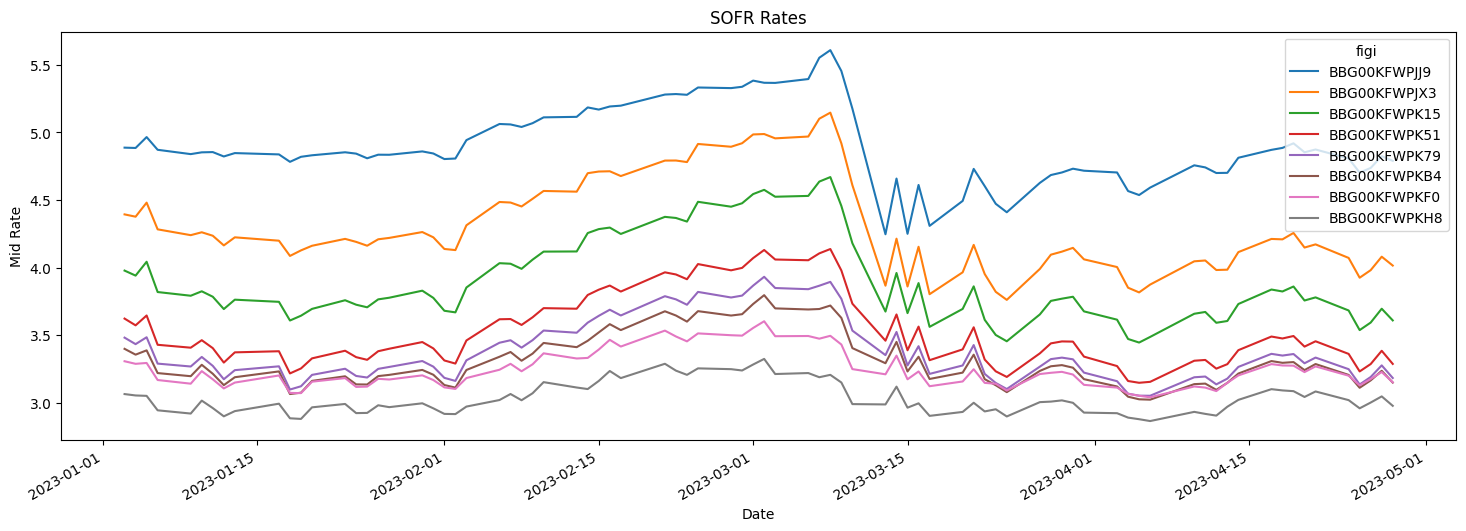

In [199]:
# Filter the DataFrame to include only the necessary columns
plot_data = sofr_swaps[['date', 'figi', 'mid_rate']]

# Pivot the DataFrame to have 'figi' as columns and 'date' as index
pivot_data = plot_data.pivot(index='date', columns='figi', values='mid_rate')

# Plot the data
pivot_data.plot(figsize=(18, 6))

# Set the plot title and labels
plt.title('SOFR Rates')
plt.xlabel('Date')
plt.ylabel('Mid Rate')

# Show the plot
plt.show()

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2023-04-28. 

Calibrate the SOFR discount factor curve as of 2023-04-28.

Follow section 11b.

In [212]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [213]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [222]:
sofr_details = pd.DataFrame(columns = ['figi','tenor','rate_quote'])
sofr_details[['figi','tenor']] = sofr_swaps_symbology[['figi','term']] 
sofr_details = sofr_details.set_index('figi')
sofr_swaps_market_data_eod.set_index('date', inplace=True)
sofr_swap_symb = sofr_swaps_market_data_eod.loc['2023-04-28']
for i in sofr_details.index:
    sofr_details.loc[i,'rate_quote'] = sofr_swap_symb.loc[sofr_swap_symb['figi'] == i,'mid_rate'].values[0]

In [224]:
sofr_details

,tenor,rate_quote
figi,,
BBG00KFWPJJ9,1,4.79
BBG00KFWPJX3,2,4.015
BBG00KFWPK15,3,3.609
BBG00KFWPK51,5,3.287
BBG00KFWPK79,7,3.18275
BBG00KFWPKB4,10,3.14875
BBG00KFWPKF0,20,3.15105
BBG00KFWPKH8,30,2.97675


In [225]:
calc_date = ql.Date(28, 4, 2023)

# Run the calibration function
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_details, 'rate_quote')

## c. Display the calibrated SOFR discount curve dataframe

Follow section 11d to display the calibration details dataframe.

In [226]:
# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates) 

In [227]:
sofr_yield_curve_details_df

,Date,YearFrac,DiscountFactor,ZeroRate
0,2023-05-02,0.000,1.000,4.788
1,2025-05-02,2.031,0.923,3.998
2,2027-05-02,4.058,0.872,3.420
3,2029-05-02,6.089,0.825,3.204
4,2031-05-02,8.117,0.778,3.142
5,2033-05-02,10.147,0.732,3.123
6,2035-05-02,12.175,0.687,3.126
7,2037-05-02,14.206,0.646,3.129
8,2039-05-02,16.233,0.606,3.132
9,2041-05-02,18.264,0.569,3.136


## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 11c.

Text(0.5, 0, 'Date')

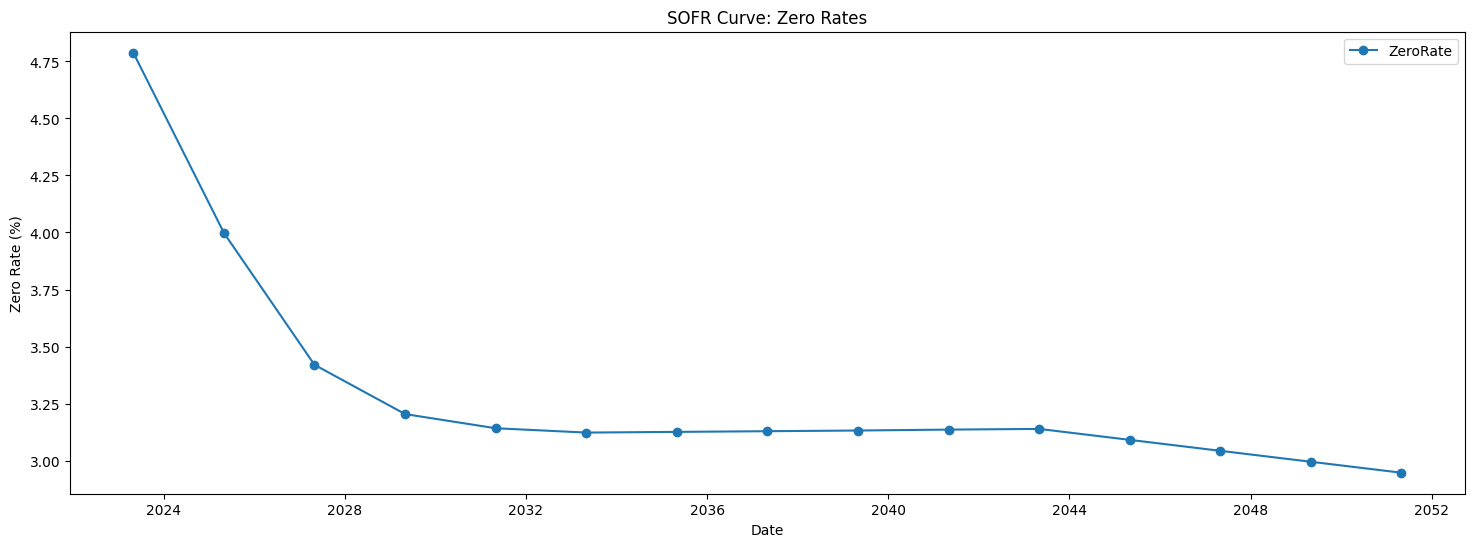

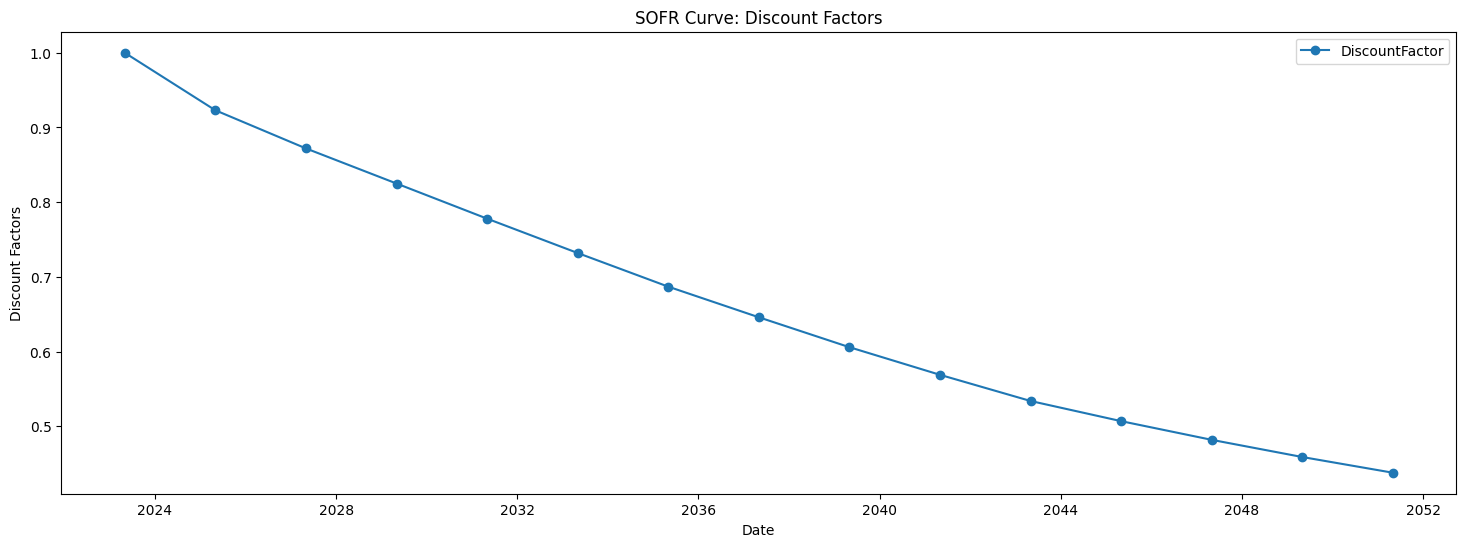

In [230]:
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', style='o-', title='SOFR Curve: Zero Rates', figsize=(18,6))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', style='o-', title='SOFR Curve: Discount Factors', figsize=(18,6))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

# Problem 4: CDS Hazard Rate calibration and valuation
## Follow Section "12. CDS Hazard Rate calibration + Pricing" in the QuantLib Intro notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


In [37]:
cds_market_data_eod = pd.read_excel('cds_market_data_eod.xlsx')
cds_market_data_eod

,date,ticker,short_name,tier,sector,region,currency,doc_clause,running_coupon,cds_assumed_recovery,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
0,2023-01-03,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001849,0.002584,0.003785,0.005948,0.007627,0.008438
1,2023-01-04,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001825,0.002549,0.003735,0.005837,0.007540,0.008339
2,2023-01-05,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001859,0.002566,0.003749,0.005854,0.007558,0.008354
3,2023-01-06,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001778,0.002453,0.003607,0.005647,0.007362,0.008156
4,2023-01-09,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001706,0.002368,0.003472,0.005433,0.007133,0.007920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2023-04-24,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001801,0.002507,0.003701,0.005783,0.007477,0.008231
77,2023-04-25,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001837,0.002552,0.003787,0.005927,0.007653,0.008438
78,2023-04-26,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001868,0.002618,0.003829,0.005977,0.007716,0.008502
79,2023-04-27,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,0.001794,0.002523,0.003683,0.005769,0.007513,0.008300


Text(0, 0.5, 'CDS Par Spreads')

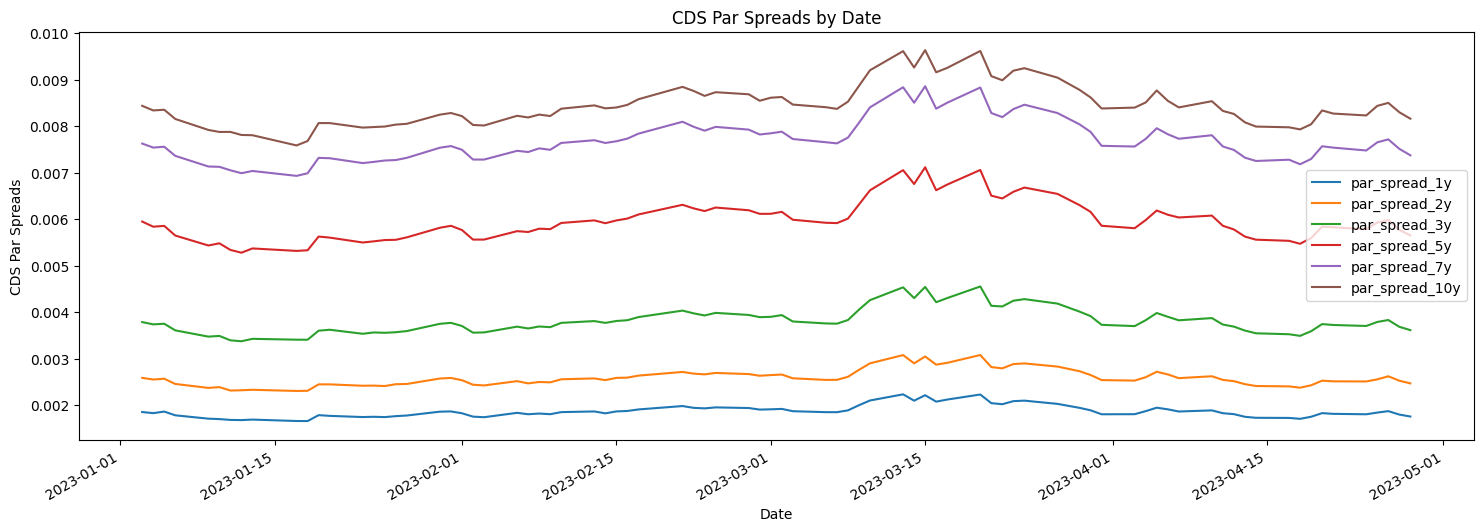

In [247]:
# Select the necessary columns for plotting
plot_data = cds_market_data_eod[['date', 'par_spread_1y', 'par_spread_2y', 'par_spread_3y', 'par_spread_5y', 'par_spread_7y', 'par_spread_10y']]

# Set the 'date' column as the index
plot_data.set_index('date', inplace=True)

# Set the plot title and labels
ax = plot_data.plot(figsize=(18, 6))
ax.set_title('CDS Par Spreads by Date')
ax.set_xlabel("Date")
ax.set_ylabel("CDS Par Spreads")


## b. Calibrate the IBM hazard rate curve as of 2023-04-28

Follow section 12a. Use the calibrated SOFR discount curve from 2b.

In [249]:
cds_market_data_eod[cds_market_data_eod['date'] == '2023-04-28'][cds_market_data_eod.columns[10:]]

,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
80,0.001752,0.002465,0.003612,0.005651,0.007374,0.008162


In [250]:
CDS_recovery_rate = 0.4
settle_days = 2

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2023-04-28
CDS_spreads = [17.52, 24.65, 36.12, 56.51, 73.74, 81.62]

sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
               
for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), hr[1] * 100, hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]
grid_dates, hazard_rates, surv_probs = zip(*hazard_list)


In [251]:
hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
hazard_rates_df

,Date,HazardRate,SurvivalProb
0,2023-04-28,0.288993,1.000000
1,2024-06-20,0.288993,0.996642
2,2025-06-20,0.550045,0.991099
3,2026-06-22,1.032387,0.980723
4,2028-06-20,1.528561,0.950832
5,2030-06-20,2.085285,0.911464
6,2033-06-20,1.749804,0.864179


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 12b. Use the calibrated SOFR discount curve from 2b.

Text(0.5, 0, 'Date')

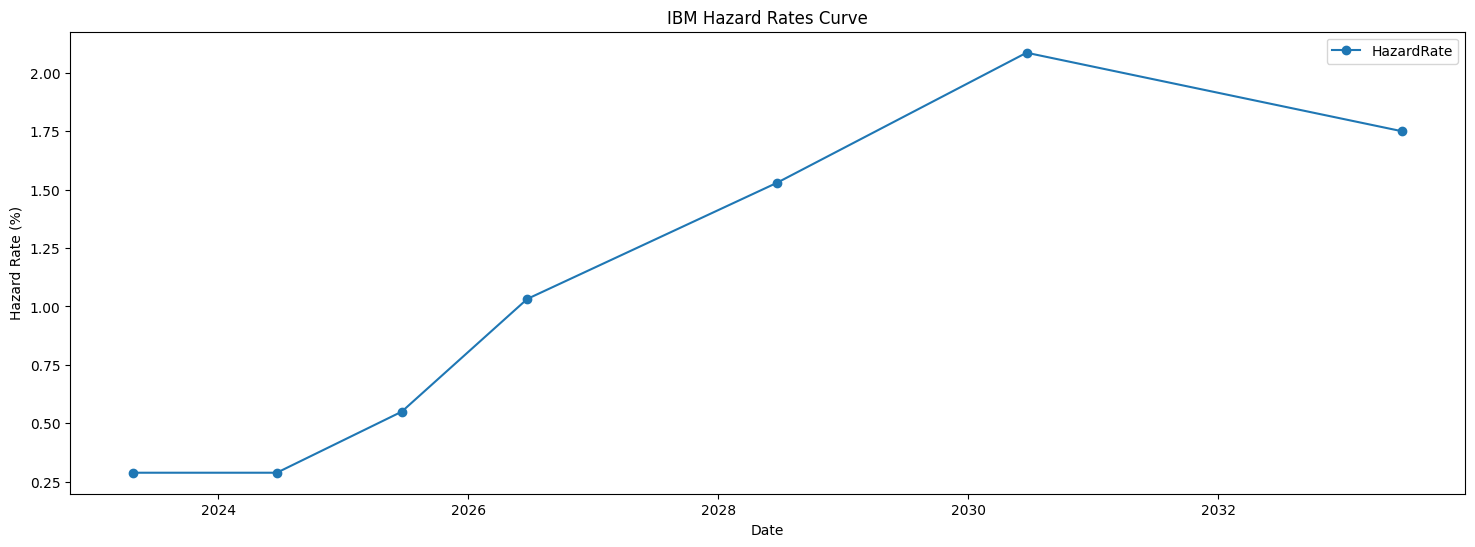

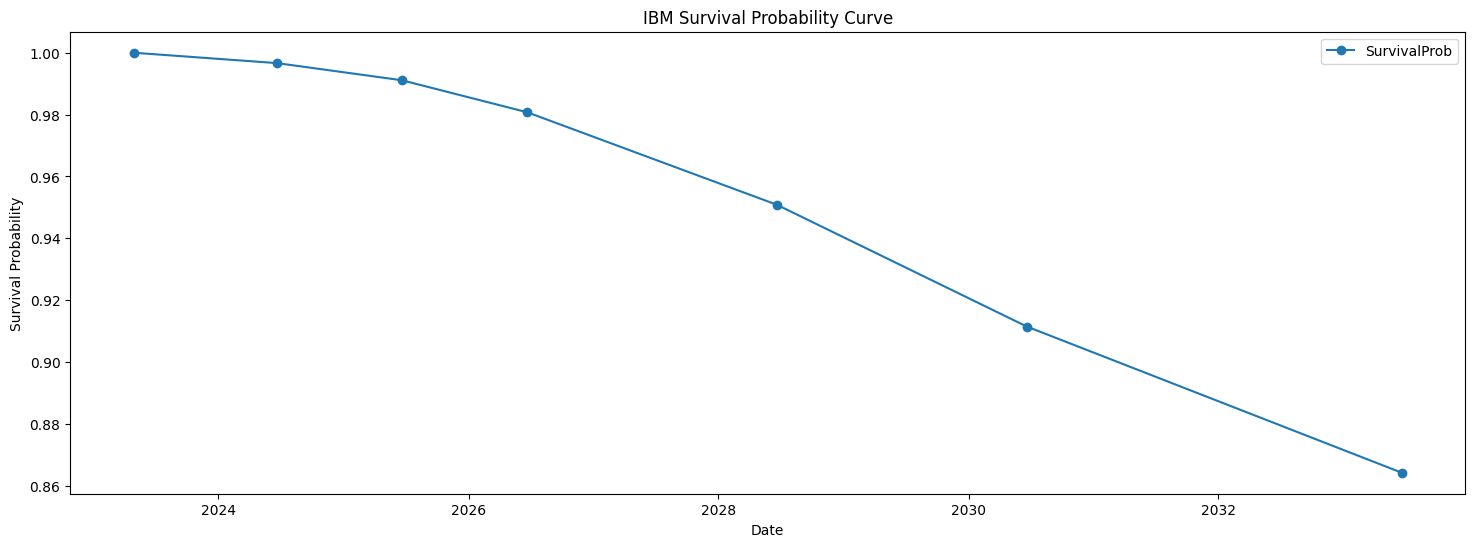

In [253]:
plt = hazard_rates_df.plot(x='Date', y='HazardRate', style='o-', title='IBM Hazard Rates Curve', figsize=(18,6))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', style='o-', title='IBM Survival Probability Curve', figsize=(18,6))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')

## d. Compute the fair/par spread and PV of a CDS 

Follow section 12c. Construct a CDS object with 100 bps coupon and 2027-06-20 maturity. Compute the fair/par spread and PV.




In [254]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(14, 4, 2023)
cds_maturity_date = ql.Date(20, 6, 2027)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS pricing engine
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_engine)


# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))


CDS protection start date: April 14th, 2023
CDS fair/par spread: 48.167
CDS PV: 2.0065
CDS Premium Leg PV: 3.8711
CDS Default Leg PV -1.8646
Survival Prob. to Maturity: 0.9657
